In [573]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from matplotlib.colors import ListedColormap

In [574]:
IN_DIRECTORY = 'data/final/'
OUT_DIRECTORY = 'data/predictions/'

In [575]:
DATA_COLUMNS = [
    'PTS', # Total Points
    'REB', # Total Rebounds
    'AST', # Total Assists
    'STL', # Total Steals
    'BLK', # Total Blocks
    'OFF_RATING', # Offensive Rating
    'DEF_RATING', # Defensive Rating
    'TS_PCT', # True Shooting percentage
    'USG_PCT', # Usage percentage
    'PIE', # Player Impact Estimate
    'WS', # Win Shares
    'PER' # Player Efficiency Rating
]

In [576]:
# get training data
train = pd.read_csv(IN_DIRECTORY + 'player_stats_training.csv')

# remove ineligible players 
# (potential outliers for advanced stats like PIE and PER due to low extremely low sample sizes)
# train = train.loc[~((train['GP'] < 15) | (train['MIN'] < 250))]

# train

In [577]:
# use Random Forest Classifier
np.random.seed(6)
X = train[DATA_COLUMNS]
y = train['ALL_NBA']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

rfModel = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
rfModel.fit(X_train, y_train)

print('Score:', rfModel.score(X_valid, y_valid))


Score: 0.9824368825466521


In [578]:
# get data for the 2022_23 to make predictions on
playerStats2022_23 = pd.read_csv(IN_DIRECTORY + 'player_stats_2022-23.csv')

allNBAwinners = playerStats2022_23['ALL_NBA']

In [579]:
# make predictions
allNBApredictions2022_23 = rfModel.predict(playerStats2022_23[DATA_COLUMNS])

print('Accuracy score:', accuracy_score(allNBAwinners, allNBApredictions2022_23))

Accuracy score: 0.9871794871794872


In [580]:
# add our new all-nba predictions to 2022-23 season player stats
playerStats2022_23['ALL_NBA_PRED'] = pd.DataFrame(allNBApredictions2022_23)

# get only players that either were all-nba or were predicted to be all-nba
allNBAplayersAndPredictions = playerStats2022_23[(playerStats2022_23['ALL_NBA'] == 1) | ( playerStats2022_23['ALL_NBA_PRED'] == 1)]

# add column that shows wether or not the prediction was correct
allNBAplayersAndPredictions['CORRECT'] = allNBAplayersAndPredictions.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)
playerStats2022_23['CORRECT'] = playerStats2022_23.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)

# sort by correct predictions
allNBAplayersAndPredictions = allNBAplayersAndPredictions.sort_values(by='CORRECT')

C:\Users\mikae\AppData\Local\Temp\ipykernel_23352\168829219.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allNBAplayersAndPredictions['CORRECT'] = allNBAplayersAndPredictions.apply(lambda x : 'YES' if x['ALL_NBA'] == x['ALL_NBA_PRED'] else 'NO', axis=1)


In [581]:
# save results
allNBAplayersAndPredictions = allNBAplayersAndPredictions[
    ['CORRECT', 'PLAYER_NAME', 'ALL_NBA', 'ALL_NBA_PRED']] 
    #  'PTS','REB','AST', 'STL','BLK','OFF_RATING','DEF_RATING','TS_PCT','USG_PCT','PIE',
    # # 'WS',
    # 'PER']]
allNBAplayersAndPredictions.to_csv(OUT_DIRECTORY + 'allNBA_predictions_2022-23.csv', index=False)

In [582]:
# show results
correctCount = allNBAplayersAndPredictions[allNBAplayersAndPredictions['CORRECT'] == 'YES'].shape[0]
predictionsMade = allNBAplayersAndPredictions[allNBAplayersAndPredictions['ALL_NBA_PRED'] == 1].shape[0]

print('Every season, exactly 15 players are selected to All-NBA teams.\nUnfortunately, our model doesnt not always choose 15 All-NBA players and we cannot force our model to \
choose exactly 15 players as All-NBA players, hence the two following accuracy scores.\n')
print('Predictions made: {}, Correct predictions: {}'.format(predictionsMade, correctCount))
print('Prediction accuracy: {}/{} = {:.3f}'.format(correctCount, predictionsMade, (correctCount / predictionsMade)))
print('True accuracy: {}/{} = {:.3f}'.format(correctCount, 15, (correctCount / 15)))
allNBAplayersAndPredictions

Every season, exactly 15 players are selected to All-NBA teams.
Unfortunately, our model doesnt not always choose 15 All-NBA players and we cannot force our model to choose exactly 15 players as All-NBA players, hence the two following accuracy scores.

Predictions made: 15, Correct predictions: 12
Prediction accuracy: 12/15 = 0.800
True accuracy: 12/15 = 0.800


,CORRECT,PLAYER_NAME,ALL_NBA,ALL_NBA_PRED
20,NO,Anthony Davis,0,1
246,NO,Julius Randle,1,0
205,NO,Jaylen Brown,1,0
171,NO,Ja Morant,0,1
433,NO,Trae Young,0,1
96,NO,De'Aaron Fox,1,0
148,YES,Giannis Antetokounmpo,1,1
117,YES,Domantas Sabonis,1,1
411,YES,Stephen Curry,1,1
216,YES,Jimmy Butler,1,1


Every season, exactly 15 players are selected to All-NBA teams. Unfortunately, our model doesnt not always choose 15 All-NBA players and we cannot force our model to choose exactly 15 players as All-NBA players. This is why I calculated two accuracy scores for cases where our model selects more or less than 15 players as All-NBA.

Luckily, the current random seed did in fact lead to our model predicting 15 All-NBA players. Our model correctly predicted 12 out of 15 All-NBA players resulting in an accuracy of 80%.

In [583]:
# PCA analysis
pca = PCA(2)
X = playerStats2022_23[DATA_COLUMNS]
X2 = pca.fit_transform(StandardScaler().fit_transform(X))

In [584]:
# print variance ratio
print(pca.explained_variance_ratio_)
# print principle components
print(pca.components_)
# print features
print(DATA_COLUMNS)

[0.47509078 0.15548652]
[[ 0.37769649  0.3297008   0.31806004  0.29778405  0.22758589  0.28236054
   0.04151527  0.20480592  0.28673724  0.36377371  0.19631375  0.36128212]
 [ 0.18754015 -0.17173777  0.22163299  0.09507413 -0.33855029 -0.10088183
   0.45395661 -0.3338517   0.36579772 -0.04527677 -0.52396523  0.15636506]]
['PTS', 'REB', 'AST', 'STL', 'BLK', 'OFF_RATING', 'DEF_RATING', 'TS_PCT', 'USG_PCT', 'PIE', 'WS', 'PER']


From the variance ratio is seems that the first principle component is much more important than the second principle componenet.

#### First principle component
Top 5 features in order of decreasing variance:
1. `Points`
2. `Player Impact Estimate`
3. `Player Efficiency Rating`
4. `Rebounds`
5. `Assists`

All of the features seem to be fairly weighted with `Points` having the highest variance. The only exception was `Defensive Rating` which had a much lower variance compared to the others.

#### Second principle component
Top 5 features in order of decreasing variance:
1. `Defensive Rating`
2. `Usage Percentage`
3. `Assists`
4. `Points`
5. `Player Efficiency Rating`

The second principle component valued `Defensive Rating` the most, which could explain the exception in the first component. `Usage Percentage` also had a much higher variance than the rest of the features.

Both principle components had higher variances for `Points`, `Assists`, and `Player Efficiency Rating` which indicates that these are the most important stats for selecting All-NBA players.

In [585]:
sns.set_theme()

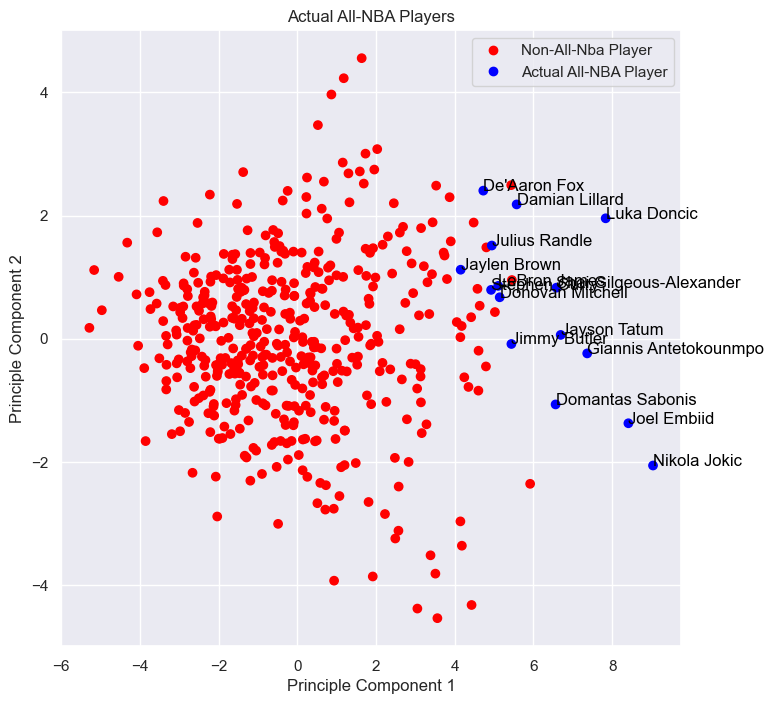

In [586]:
plt.figure(figsize=(8,8))
colors = ListedColormap(['red','blue'])

scatter = plt.scatter(X2[:, 0], X2[:, 1], c=playerStats2022_23['ALL_NBA'], cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=['Non-All-Nba Player', 'Actual All-NBA Player'])
for i, (x, y) in enumerate(zip(X2[:, 0], X2[:, 1])):
    if playerStats2022_23['ALL_NBA'][i] == 1:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='black')#, alpha=0.8)#, rotation=20.0)
plt.title('Actual All-NBA Players')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()

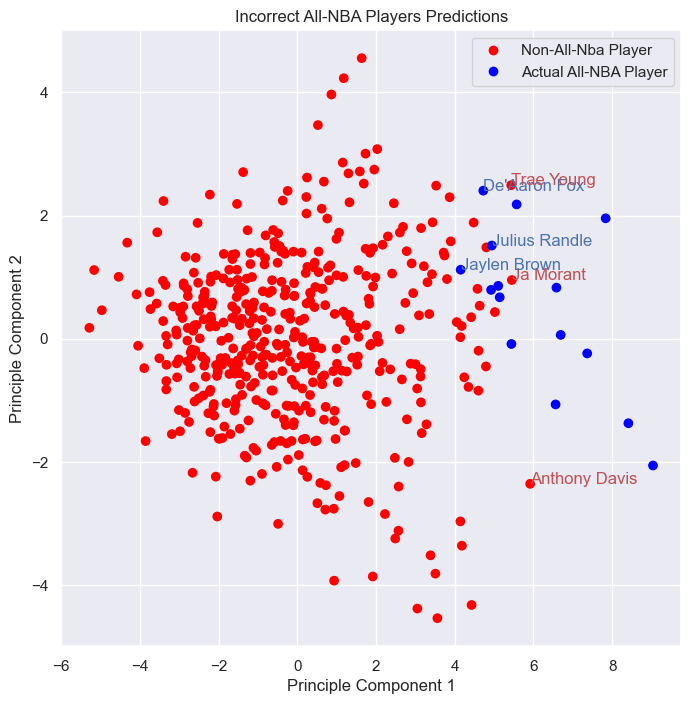

In [587]:
# incorrect predictions, model believed these players deserved to be all-stars
plt.figure(figsize=(8,8))

scatter = plt.scatter(X2[:, 0], X2[:, 1], c=playerStats2022_23['ALL_NBA'], cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=['Non-All-Nba Player', 'Actual All-NBA Player'])
for i, (x, y) in enumerate(zip(X2[:, 0], X2[:, 1])):

    if (playerStats2022_23['ALL_NBA_PRED'][i] != playerStats2022_23['ALL_NBA'][i]) and playerStats2022_23['ALL_NBA'][i] == 0:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='r')#, alpha=0.8)
    if (playerStats2022_23['ALL_NBA_PRED'][i] != playerStats2022_23['ALL_NBA'][i]) and playerStats2022_23['ALL_NBA'][i] == 1:
        plt.text(x, y, playerStats2022_23['PLAYER_NAME'][i], color='b')#, alpha=0.8)
plt.title('Incorrect All-NBA Players Predictions')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.show()

In [588]:
# finally, I wanted to make predictions on the current season (2023-24) just for fun!
# we won't be able to test the accuracy of these predictions as the All-NBA teams for this season haven't been selected yet!

# get data
playerStats2023_24 = pd.read_csv(IN_DIRECTORY + 'player_stats_2023-24.csv')

# make prediction
allNBApredictions2023_24 = rfModel.predict(playerStats2023_24[DATA_COLUMNS])

# add predictions to data
playerStats2023_24['ALL_NBA_PRED'] = pd.DataFrame(allNBApredictions2023_24)

# get only players that were predicted to be all-nba
playerStats2023_24 = playerStats2023_24[playerStats2023_24['ALL_NBA_PRED'] == 1]

# save results
playerStats2023_24 = playerStats2023_24[
    ['PLAYER_NAME', 'ALL_NBA_PRED']] 

playerStats2023_24.to_csv(OUT_DIRECTORY + 'allNBA_predictions_2023-24.csv', index=False)